# Current solution 

In [ ]:
arguments = ['0', '59', '1', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '1440', 'SECOND', '/home/ali/matrices/60_1', 'mobilitydb', 'processed_data', 'MMSI', 'traj']
arguments

In [ ]:
"""

File used to create the matrices for the time deltas between the begin_frame and end_frame.

The matrices are saved in the /home/ali/matrices/ folder.


            # arguments :[ 
            # 0: begin_frame, 
            # 1: end_frame, 
            # 2: PERCENTAGE_OF_OBJECTS, 
            # 3: x_min, 4: y_min, 5: x_max, 6: y_max, 
            # 7: start_timestamp, 
            # 8: total_frames, 
            # 9: granularity, 
            # 10: matrix_directory_path, 
            # 11: database_name, 
            # 12: table_name, 
            # 13: id_column_name, 
            # 14: tpoint_column_name]

To measure the size of matrices folder : du -sh --block-size=MB matrices            

"""

import numpy as np
from shapely.geometry import Point
from pymeos.db.psycopg import MobilityDB

from pymeos import *
import os
import sys
from datetime import timedelta, datetime
from pymeos import *
import time

logs = ""
now = time.time()


args = arguments
logs += f"Args: {args}\n"
begin_frame = int(args[0])
end_frame = int(args[1])
TIME_DELTA_SIZE = end_frame - begin_frame + 1
PERCENTAGE_OF_OBJECTS = float(args[2])


SRID = 4326


DATABASE_NAME = args[11]
TPOINT_TABLE_NAME = args[12]
TPOINT_ID_COLUMN_NAME = args[13]
TPOINT_COLUMN_NAME = args[14]



class Database_connector:
    """
    Singleton class used to connect to the MobilityDB database.
    """
    
    def __init__(self):
        try: 
            connection_params = {
            "host": "localhost",
            "port": 5432,
            "dbname": DATABASE_NAME,
            "user": "postgres",
            "password": "postgres"
            }
            self.table_name = TPOINT_TABLE_NAME
            self.id_column_name = TPOINT_ID_COLUMN_NAME
            self.tpoint_column_name = TPOINT_COLUMN_NAME               
            self.connection = MobilityDB.connect(**connection_params)

            self.cursor = self.connection.cursor()

            self.cursor.execute(f"SELECT {self.id_column_name} FROM public.{self.table_name};")
            self.ids_list = self.cursor.fetchall()
            self.ids_list = self.ids_list[:int(len(self.ids_list)*PERCENTAGE_OF_OBJECTS)]
        except Exception as e:
            pass

  
    def get_subset_of_tpoints(self, pstart, pend, xmin, ymin, xmax, ymax):
        """
        For each object in the ids_list :
            Fetch the subset of the associated Tpoints between the start and end timestamps
            contained in the STBOX defined by the xmin, ymin, xmax, ymax.
        """
        try:
           
            ids_list = [ f"'{id[0]}'"  for id in self.ids_list]
            ids_str = ', '.join(map(str, ids_list))
          
            query = f"""
                    SELECT 
                        atStbox(
                            a.{self.tpoint_column_name}::tgeompoint,
                            stbox(
                                ST_MakeEnvelope(
                                    {xmin}, {ymin}, -- xmin, ymin
                                    {xmax}, {ymax}, -- xmax, ymax
                                    4326 -- SRID
                                ),
                                tstzspan('[{pstart}, {pend}]')
                            )
                        )
                    FROM public.{self.table_name} as a 
                    WHERE a.{self.id_column_name} in ({ids_str});
                    """
            self.cursor.execute(query)
            # print(query)
            rows = self.cursor.fetchall()
            return rows
        except Exception as e:
            # print(e)
            pass


    def close(self):
        """
        Close the connection to the MobilityDB database.
        """
        self.cursor.close()
        self.connection.close()


MATRIX_DIRECTORY_PATH = "/home/ali/matrices"
file_name = f"{args[10]}/matrix_{begin_frame}.npy"


  
Time_granularities = {
                    # "MILLISECOND" : timedelta(milliseconds=1),
                      "SECOND" : timedelta(seconds=1),
                      "MINUTE" : timedelta(minutes=1),
                    #   "HOUR" : timedelta(hours=1),
                    }



pymeos_initialize()
db = Database_connector()

x_min = float(args[3])
y_min = float(args[4])
x_max = float(args[5])
y_max = float(args[6])

start_date = args[7]
start_date = datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S')


total_frames = int(args[8])
GRANULARITY = Time_granularities[args[9]]

timestamps = []
for i in range(total_frames): 
    timestamps.append(start_date + i*GRANULARITY)



p_start = timestamps[begin_frame]
p_end = timestamps[end_frame]
# print(p_start, p_end, x_min, y_min, x_max, y_max)
now_db = time.time()
rows = db.get_subset_of_tpoints(p_start, p_end, x_min, y_min, x_max, y_max)    


In [ ]:
logs += f"Time to fetch subset of tpoints: {time.time() - now_db} seconds\n"
        
empty_point_wkt = Point().wkt  # "POINT EMPTY"
matrix = np.full((len(rows), TIME_DELTA_SIZE), empty_point_wkt, dtype=object)

time_ranges = timestamps
now = time.time()

for i in range(len(rows)):
    try:
        traj = rows[i][0]
        traj = traj.temporal_precision(GRANULARITY) 
        num_instants = traj.num_instants()
        if num_instants == 0:
            continue
        elif num_instants == 1:
            single_timestamp = traj.timestamps()[0].replace(tzinfo=None)
            index = time_ranges.index(single_timestamp) - begin_frame
            matrix[i][index] = traj.values()[0].wkt
        
        elif num_instants >= 2:
            traj_resampled = traj.temporal_sample(start=time_ranges[0],duration= GRANULARITY)
            
            start_index = time_ranges.index( traj_resampled.start_timestamp().replace(tzinfo=None) ) - begin_frame
            end_index = time_ranges.index( traj_resampled.end_timestamp().replace(tzinfo=None) ) - begin_frame
    
            trajectory_array = np.array([point.wkt for point in traj_resampled.values()])
            matrix[i, start_index:end_index+1] = trajectory_array

    except:
        continue

np.save(file_name, matrix)

db.close()
pymeos_finalize()
total_time = time.time() - now
frames_for_30_fps= 30 * total_time
print(f"================================================================     Matrix {begin_frame} created in {total_time} seconds, {frames_for_30_fps} frames for 30 fps animation.")
logs += f"time to create and fill the matrix {begin_frame}: {total_time} seconds\n"


# With resample in the database query

In [7]:

import numpy as np
from shapely.geometry import Point
from pymeos.db.psycopg import MobilityDB

from pymeos import *
import os
import sys
from datetime import timedelta, datetime
from pymeos import *
import time

logs = ""
now = time.time()

FPS_DEQUEUE_SIZE = 5 # Length of the dequeue to calculate the average FPS
TIME_DELTA_DEQUEUE_SIZE =  10 # Length of the dequeue to keep the keys to keep in the buffer


args = sysargs
logs += f"Args: {args}\n"
begin_frame = int(args[0])
end_frame = int(args[1])
TIME_DELTA_SIZE = end_frame - begin_frame + 1
PERCENTAGE_OF_OBJECTS = float(args[2])


SRID = 4326


DATABASE_NAME = args[11]
TPOINT_TABLE_NAME = args[12]
TPOINT_ID_COLUMN_NAME = args[13]
TPOINT_COLUMN_NAME = args[14]



class Database_connector2:
    """
    Singleton class used to connect to the MobilityDB database.
    """
    
    def __init__(self):
        try: 
            connection_params = {
            "host": "localhost",
            "port": 5432,
            "dbname": DATABASE_NAME,
            "user": "postgres",
            "password": "postgres"
            }
            self.table_name = TPOINT_TABLE_NAME
            self.id_column_name = TPOINT_ID_COLUMN_NAME
            self.tpoint_column_name = TPOINT_COLUMN_NAME               
            self.connection = MobilityDB.connect(**connection_params)

            self.cursor = self.connection.cursor()

            self.cursor.execute(f"SELECT {self.id_column_name} FROM public.{self.table_name};")
            self.ids_list = self.cursor.fetchall()
            self.ids_list = self.ids_list[:int(len(self.ids_list)*PERCENTAGE_OF_OBJECTS)]
        except Exception as e:
            pass

  
    def get_subset_of_tpoints(self, pstart, pend, xmin, ymin, xmax, ymax):
        """
        For each object in the ids_list :
            Fetch the subset of the associated Tpoints between the start and end timestamps
            contained in the STBOX defined by the xmin, ymin, xmax, ymax.
        """
        try:
           
            ids_list = [ f"'{id[0]}'"  for id in self.ids_list]
            ids_str = ', '.join(map(str, ids_list))
          
            query = f"""
                    WITH trajectories as (
                    SELECT 
                        atStbox(
                            a.{self.tpoint_column_name}::tgeompoint,
                            stbox(
                                ST_MakeEnvelope(
                                    {xmin}, {ymin}, -- xmin, ymin
                                    {xmax}, {ymax}, -- xmax, ymax
                                    4326 -- SRID
                                ),
                                tstzspan('[{pstart}, {pend}]')
                            )
                        ) as trajectory
                    FROM public.{self.table_name} as a 
                    WHERE a.{self.id_column_name} in ({ids_str}))

                    SELECT tsample(trajectory, INTERVAL '1 minute', TIMESTAMP '2023-06-01 00:00:00')  AS resampled_trajectory
                        FROM 
                            trajectories ;
 
                    """
            self.cursor.execute(query)
            # print(query)
            rows = self.cursor.fetchall()
            return rows
        except Exception as e:
            # print(e)
            pass


    def get_min_timestamp(self):
        """
        Returns the min timestamp of the tpoints columns.

        """
        try:
            
            self.cursor.execute(f"SELECT MIN(startTimestamp({self.tpoint_column_name})) AS earliest_timestamp FROM public.{self.table_name};")
            return self.cursor.fetchone()[0]
        except Exception as e:
            pass

    def get_max_timestamp(self):
        """
        Returns the max timestamp of the tpoints columns.

        """
        try:
            self.cursor.execute(f"SELECT MAX(endTimestamp({self.tpoint_column_name})) AS latest_timestamp FROM public.{self.table_name};")
            return self.cursor.fetchone()[0]
        except Exception as e:
            pass


    def close(self):
        """
        Close the connection to the MobilityDB database.
        """
        self.cursor.close()
        self.connection.close()


MATRIX_DIRECTORY_PATH = "/home/ali/matrices"
file_name = f"/home/ali/matrices/matrix_{begin_frame}.npy"


  
Time_granularities = {
                    # "MILLISECOND" : timedelta(milliseconds=1),
                      "SECOND" : timedelta(seconds=1),
                      "MINUTE" : timedelta(minutes=1),
                    #   "HOUR" : timedelta(hours=1),
                    }


# check if file does't already exist

pymeos_initialize()
db = Database_connector2()

x_min = float(args[3])
y_min = float(args[4])
x_max = float(args[5])
y_max = float(args[6])

start_date = args[7]
start_date = datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S')


total_frames = int(args[8])
GRANULARITY = Time_granularities[args[9]]

timestamps = []
for i in range(total_frames): 
    timestamps.append(start_date + i*GRANULARITY)



p_start = timestamps[begin_frame]
p_end = timestamps[end_frame]
# print(p_start, p_end, x_min, y_min, x_max, y_max)
now_db = time.time()
rows = db.get_subset_of_tpoints(p_start, p_end, x_min, y_min, x_max, y_max)    

print(f"Time to fetch tpoints : {time.time() - now_db} s")    
        

Time to fetch tpoints : 1.8734567165374756 s


In [15]:
empty_point_wkt = Point()  # "POINT EMPTY"
matrix = np.full((len(rows), TIME_DELTA_SIZE), empty_point_wkt, dtype=object)

time_ranges = timestamps
now = time.time()

# try:
for i in range(len(rows)):
    if rows[i][0] is not None:
        try:
            traj_resampled = rows[i][0]

            start_index = time_ranges.index( traj_resampled.start_timestamp().replace(tzinfo=None).replace(second=0, microsecond=0) ) - begin_frame
            end_index = time_ranges.index( traj_resampled.end_timestamp().replace(tzinfo=None).replace(second=0, microsecond=0) ) - begin_frame
            matrix[i, start_index:end_index+1] = np.array(traj_resampled.values())
    
        except:
            print(i)
            # continue


# db.close()
# pymeos_finalize()
total_time = time.time() - now
frames_for_30_fps= 30 * total_time
print(f"Matrix {begin_frame} created in {total_time} seconds, {frames_for_30_fps} frames for 30 fps animation.")
# logs += f"time to create and fill the matrix {begin_frame}: {total_time} seconds\n"


Matrix 0 created in 15.015557765960693 seconds, 450.4667329788208 frames for 30 fps animation.


In [32]:
np.count_nonzero(matrix != 'POINT EMPTY')

2794080

In [26]:
%load_ext line_profiler

In [29]:
def opr(rows):
    empty_point_wkt = Point()  # "POINT EMPTY"
    matrix = np.full((len(rows), TIME_DELTA_SIZE), empty_point_wkt, dtype=object)

    time_ranges = timestamps
    now = time.time()

    for i in range(len(rows)):
        if rows[i][0] is not None:
            try:
                traj_resampled = rows[i][0]
                # num_instants = traj_resampled.num_instants()
                # if num_instants == 1:
                #     # print(f"{i} has one instant")
                #     single_timestamp = traj_resampled.timestamps()[0].replace(tzinfo=None).replace(second=0, microsecond=0)
                #     index = time_ranges.index(single_timestamp) - begin_frame
                #     matrix[i][index] = traj.values()[0].wkt
                
                # elif num_instants >= 2:
                    # traj_resampled = traj.temporal_sample(start=time_ranges[0],duration= GRANULARITY)
                    
                start_index = time_ranges.index( traj_resampled.start_timestamp().replace(tzinfo=None).replace(second=0, microsecond=0) ) - begin_frame
                end_index = time_ranges.index( traj_resampled.end_timestamp().replace(tzinfo=None).replace(second=0, microsecond=0) ) - begin_frame
                vals = traj_resampled.values()
                trajectory_array = np.array(vals)
                matrix[i, start_index:end_index+1] = trajectory_array
        
            except:
                continue


    # db.close()
    # pymeos_finalize()
    total_time = time.time() - now
    frames_for_30_fps= 30 * total_time
    print(f"Matrix {begin_frame} created in {total_time} seconds, {frames_for_30_fps} frames for 30 fps animation.")
    # logs += f"time to create and fill the matrix {begin_frame}: {total_time} seconds\n"

    

In [30]:
%lprun -f opr opr(rows)

Matrix 0 created in 25.74210810661316 seconds, 772.2632431983948 frames for 30 fps animation.


Timer unit: 1e-09 s

Total time: 25.1043 s
File: /tmp/ipykernel_5042/310096134.py
Function: opr at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def opr(rows):
     2         1      54306.0  54306.0      0.0      empty_point_wkt = Point()  # "POINT EMPTY"
     3         1    6041035.0    6e+06      0.0      matrix = np.full((len(rows), TIME_DELTA_SIZE), empty_point_wkt, dtype=object)
     4                                           
     5         1        392.0    392.0      0.0      time_ranges = timestamps
     6         1        716.0    716.0      0.0      now = time.time()
     7                                           
     8      5822    1132901.0    194.6      0.0      for i in range(len(rows)):
     9      5821    1072371.0    184.2      0.0          if rows[i][0] is not None:
    10      4174     365683.0     87.6      0.0              try:
    11      4174     670280.0    160.6      0.0             

In [22]:
now = time.time()

for i in range(len(rows)):
    if rows[i][0] is not None:
        try:
            traj_resampled = rows[i][0]

            start_index = time_ranges.index( traj_resampled.start_timestamp().replace(tzinfo=None).replace(second=0, microsecond=0) ) - begin_frame
            end_index = time_ranges.index( traj_resampled.end_timestamp().replace(tzinfo=None).replace(second=0, microsecond=0) ) - begin_frame
            vals = traj_resampled.values()
            trajectory_array = np.array([point.wkt for point in vals])
            matrix[i, start_index:end_index+1] = trajectory_array

        except:
            continue
        
print(f" Time to fill the matrix : {time.time() - now} s")

 Time to fill the matrix : 19.8060622215271 s


In [24]:
x1 = TGeomPointInst(point=(0, 0), timestamp=timestamps[0])
x2 = TGeomPointInst(point=(1, 1), timestamp=timestamps[TIME_DELTA_SIZE-1])
traj = TGeomPointSeq.from_instants([x1, x2], upper_inc=True)
traj_resampled = traj.temporal_sample(start=timestamps[0],duration= GRANULARITY)
empty_point_wkt = Point().wkt  # "POINT EMPTY"
matrix = np.full((len(rows), TIME_DELTA_SIZE), empty_point_wkt, dtype=object)
trajectory_array = np.array([point.wkt for point in traj_resampled.values()])
trajectory_array

now = time.time()

for i in range(len(rows)):
    if 1 == 1 :
        try:
            start_index = timestamps.index( traj_resampled.start_timestamp().replace(tzinfo=None).replace(second=0, microsecond=0) ) 
            end_index = timestamps.index( traj_resampled.end_timestamp().replace(tzinfo=None).replace(second=0, microsecond=0) ) 

            trajectory_array = np.array([point.wkt for point in traj_resampled.values()])
            matrix[i, start_index:end_index+1] = trajectory_array
        except:
            continue
print(f"Time to fill the matrix : {time.time() - now} s")

Time to fill the matrix : 23.57325553894043 s


In [28]:
%lprun -f opr opr(rows)

Matrix 0 created in 34.37529969215393 seconds, 1031.258990764618 frames for 30 fps animation.


Timer unit: 1e-09 s

Total time: 33.4186 s
File: /tmp/ipykernel_5042/2884772419.py
Function: opr at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def opr(rows):
     2         1      68870.0  68870.0      0.0      empty_point_wkt = Point()  # "POINT EMPTY"
     3         1    6289944.0    6e+06      0.0      matrix = np.full((len(rows), TIME_DELTA_SIZE), empty_point_wkt, dtype=object)
     4                                           
     5         1        410.0    410.0      0.0      time_ranges = timestamps
     6         1        889.0    889.0      0.0      now = time.time()
     7                                           
     8      5822    1172389.0    201.4      0.0      for i in range(len(rows)):
     9      5821    1257898.0    216.1      0.0          if rows[i][0] is not None:
    10      4174     417364.0    100.0      0.0              try:
    11      4174     507546.0    121.6      0.0            

In [12]:
pip install line_profiler

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 720.6/720.6 kB 8.2 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [9]:
np.count_nonzero(matrix != 'POINT EMPTY')

865790

# With indexing and resampling in database

In [12]:

import numpy as np
from shapely.geometry import Point
from pymeos.db.psycopg import MobilityDB

from pymeos import *
import os
import sys
from datetime import timedelta, datetime
from pymeos import *
import time

logs = ""
now = time.time()

FPS_DEQUEUE_SIZE = 5 # Length of the dequeue to calculate the average FPS
TIME_DELTA_DEQUEUE_SIZE =  10 # Length of the dequeue to keep the keys to keep in the buffer


args = sysargs
logs += f"Args: {args}\n"
begin_frame = int(args[0])
end_frame = int(args[1])
TIME_DELTA_SIZE = end_frame - begin_frame + 1
PERCENTAGE_OF_OBJECTS = float(args[2])


SRID = 4326


DATABASE_NAME = args[11]
TPOINT_TABLE_NAME = args[12]
TPOINT_ID_COLUMN_NAME = args[13]
TPOINT_COLUMN_NAME = args[14]



class Database_connector3:
    """
    Singleton class used to connect to the MobilityDB database.
    """
    
    def __init__(self):
        try: 
            connection_params = {
            "host": "localhost",
            "port": 5432,
            "dbname": DATABASE_NAME,
            "user": "postgres",
            "password": "postgres"
            }
            self.table_name = TPOINT_TABLE_NAME
            self.id_column_name = TPOINT_ID_COLUMN_NAME
            self.tpoint_column_name = TPOINT_COLUMN_NAME               
            self.connection = MobilityDB.connect(**connection_params)

            self.cursor = self.connection.cursor()

            self.cursor.execute(f"SELECT {self.id_column_name} FROM public.{self.table_name};")
            self.ids_list = self.cursor.fetchall()
            self.ids_list = self.ids_list[:int(len(self.ids_list)*PERCENTAGE_OF_OBJECTS)]
        except Exception as e:
            pass

  
    def get_subset_of_tpoints(self, pstart, pend, xmin, ymin, xmax, ymax):
        """
        For each object in the ids_list :
            Fetch the subset of the associated Tpoints between the start and end timestamps
            contained in the STBOX defined by the xmin, ymin, xmax, ymax.
        """
        try:
           
            ids_list = [ f"'{id[0]}'"  for id in self.ids_list]
            ids_str = ', '.join(map(str, ids_list))
          
            query = f"""
                    WITH trajectories as (
                    SELECT 
                        atStbox(
                            a.{self.tpoint_column_name}::tgeompoint,
                            stbox(
                                ST_MakeEnvelope(
                                    {xmin}, {ymin}, -- xmin, ymin
                                    {xmax}, {ymax}, -- xmax, ymax
                                    4326 -- SRID
                                ),
                                tstzspan('[{pstart}, {pend}]')
                            )
                        ) as trajectory
                    FROM public.{self.table_name} as a 
                    WHERE a.{self.id_column_name} in ({ids_str})),

                    resampled as (

                    SELECT tsample(traj.trajectory, INTERVAL '1 minute', TIMESTAMP '2023-06-01 00:00:00')  AS resampled_trajectory
                        FROM 
                            trajectories as traj)
				
                    SELECT
                            EXTRACT(EPOCH FROM (startTimestamp(rs.resampled_trajectory) - '2023-06-01 00:00:00'::timestamp))::integer / 60 AS start_index ,
                            EXTRACT(EPOCH FROM (endTimestamp(rs.resampled_trajectory) - '2023-06-01 00:00:00'::timestamp))::integer / 60 AS end_index,
                            rs.resampled_trajectory
                    FROM resampled as rs ;
 
                    """
            self.cursor.execute(query)
            # print(query)
            rows = self.cursor.fetchall()
            return rows
        except Exception as e:
            # print(e)
            pass


    def get_min_timestamp(self):
        """
        Returns the min timestamp of the tpoints columns.

        """
        try:
            
            self.cursor.execute(f"SELECT MIN(startTimestamp({self.tpoint_column_name})) AS earliest_timestamp FROM public.{self.table_name};")
            return self.cursor.fetchone()[0]
        except Exception as e:
            pass

    def get_max_timestamp(self):
        """
        Returns the max timestamp of the tpoints columns.

        """
        try:
            self.cursor.execute(f"SELECT MAX(endTimestamp({self.tpoint_column_name})) AS latest_timestamp FROM public.{self.table_name};")
            return self.cursor.fetchone()[0]
        except Exception as e:
            pass


    def close(self):
        """
        Close the connection to the MobilityDB database.
        """
        self.cursor.close()
        self.connection.close()


MATRIX_DIRECTORY_PATH = "/home/ali/matrices"
file_name = f"/home/ali/matrices/matrix_{begin_frame}.npy"


  
Time_granularities = {
                    # "MILLISECOND" : timedelta(milliseconds=1),
                      "SECOND" : timedelta(seconds=1),
                      "MINUTE" : timedelta(minutes=1),
                    #   "HOUR" : timedelta(hours=1),
                    }


# check if file does't already exist

pymeos_initialize()
db = Database_connector3()

x_min = float(args[3])
y_min = float(args[4])
x_max = float(args[5])
y_max = float(args[6])

start_date = args[7]
start_date = datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S')


total_frames = int(args[8])
GRANULARITY = Time_granularities[args[9]]

timestamps = []
for i in range(total_frames): 
    timestamps.append(start_date + i*GRANULARITY)



p_start = timestamps[begin_frame]
p_end = timestamps[end_frame]
# print(p_start, p_end, x_min, y_min, x_max, y_max)
now_db = time.time()
rows = db.get_subset_of_tpoints(p_start, p_end, x_min, y_min, x_max, y_max)    

print(f"Time to fetch tpoints : {time.time() - now_db} s")    
        

Time to fetch tpoints : 2.397526502609253 s


In [14]:
empty_point_wkt = Point()  # "POINT EMPTY"
matrix = np.full((len(rows), TIME_DELTA_SIZE), empty_point_wkt, dtype=object)

time_ranges = timestamps
now = time.time()

# try:
for i in range(len(rows)):
    if rows[i][2] is not None:
        try:
            traj_resampled = rows[i][2]

            start_index = rows[i][0] 
            end_index = rows[i][1]
            matrix[i, start_index:end_index+1] = np.array(traj_resampled.values())
    
        except:
            print(i)
            # continue


# db.close()
# pymeos_finalize()
total_time = time.time() - now
frames_for_30_fps= 30 * total_time
print(f"Matrix {begin_frame} created in {total_time} seconds, {frames_for_30_fps} frames for 30 fps animation.")
# logs += f"time to create and fill the matrix {begin_frame}: {total_time} seconds\n"


Matrix 0 created in 13.855250358581543 seconds, 415.6575107574463 frames for 30 fps animation.


In [15]:
np.count_nonzero(matrix != 'POINT EMPTY')

2794080

# Measuring nditer vs for loop for feature generation

In [29]:
%%timeit

empty_point_wkt = Point().wkt  # "POINT EMPTY"
# create a numpy array of size len(ids_list) with empty_point_wkt
starting_points = np.full((1, 5821), empty_point_wkt, dtype=object)

qgis_fields_list = []

for wkt in np.nditer(starting_points, flags=['refs_ok']):
    feat = ["vlayer_fields"]
    feat.append("datetime_obj")  # Set its attributes
    # Create geometry from WKT string
    feat.append(wkt.item())
    qgis_fields_list.append(feat)
        

962 µs ± 39.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [31]:
%%timeit

empty_point_wkt = Point().wkt  # "POINT EMPTY"

qgis_fields_list = []

for i in range(5821):
    feat = ["vlayer_fields"]
    feat.append("datetime_obj")  # Set its attributes
    # Create geometry from WKT string
    feat.append(empty_point_wkt)
    qgis_fields_list.append(feat)

378 µs ± 2.94 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


# Benchmarking Matrix generation script

In [21]:
sysargs = ['0',
 '479',
 '1',
 '-180',
 '-90',
 '180',
 '90',
 '2023-06-01 00:00:00',
 '1439',
 'MINUTE',
 '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/matrices',
 'mobilitydb',
 'processed_data',
 'MMSI',
 'traj']

sysargs

['0',
 '479',
 '1',
 '-180',
 '-90',
 '180',
 '90',
 '2023-06-01 00:00:00',
 '1439',
 'MINUTE',
 '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/matrices',
 'mobilitydb',
 'processed_data',
 'MMSI',
 'traj']

In [28]:
import numpy as np
from shapely.geometry import Point
from pymeos.db.psycopg import MobilityDB

from pymeos import *
import os
import sys
from datetime import timedelta, datetime
from pymeos import *
import time
from tqdm import tqdm
import itertools
import shutil
import math
import subprocess


MATRIX_DIRECTORY_PATH ="/home/ali/matrices/" 
if os.path.exists(MATRIX_DIRECTORY_PATH):
    shutil.rmtree(MATRIX_DIRECTORY_PATH)
    os.makedirs(MATRIX_DIRECTORY_PATH)
else:
    os.makedirs(MATRIX_DIRECTORY_PATH)
pymeos_initialize()

"""
Iterate over all the possible combinations of frames and percentages

for each combination :
    
    Create 3 time deltas
    store : time for each time delta
    store : maximum time for each time delta
    store : average time for each time delta
    
    Calculate FPS using : Frames / maximum time for each time delta

    Store the FPS for each combination

    store the memory used by all 3 time delta in local disk


"""

SRID = 4326
DATABASE_NAME = "mobilitydb"
TPOINT_TABLE_NAME = "PyMEOS_demo"
TPOINT_ID_COLUMN_NAME = "MMSI"
TPOINT_COLUMN_NAME = "trajectory"
x_min = -180
y_min = -90
x_max = 180
y_max = 90
extent_list = [x_min, y_min, x_max, y_max]
Time_granularities = {
                    # "MILLISECOND" : timedelta(milliseconds=1),
                      "SECOND" : timedelta(seconds=1),
                      "MINUTE" : timedelta(minutes=1),
                    #   "HOUR" : timedelta(hours=1),
                    }
GRANULARITY = Time_granularities["SECOND"]

connection_params = {
        "host": "localhost",
        "port": 5432,
        "dbname": DATABASE_NAME,
        "user": "postgres",
        "password": "postgres"
        }
                
connection = MobilityDB.connect(**connection_params)
cursor = connection.cursor()

cursor.execute(f"SELECT {TPOINT_ID_COLUMN_NAME} FROM public.{TPOINT_TABLE_NAME};")
Total_ids = cursor.fetchall()

cursor.execute(f"SELECT MIN(startTimestamp({TPOINT_COLUMN_NAME})) AS earliest_timestamp FROM public.{TPOINT_TABLE_NAME};")
start_date = cursor.fetchone()[0]
cursor.execute(f"SELECT MAX(endTimestamp({TPOINT_COLUMN_NAME})) AS latest_timestamp FROM public.{TPOINT_TABLE_NAME};")
end_date = cursor.fetchone()[0]

total_frames = math.ceil( (end_date - start_date) // GRANULARITY ) + 1

timestamps = [start_date + i * GRANULARITY for i in range(total_frames)]
timestamps = [dt.replace(tzinfo=None) for dt in timestamps]
timestamps_strings = [dt.strftime('%Y-%m-%d %H:%M:%S') for dt in timestamps]


TIME_DELTA_COUNT = 10


Frames = [60, 120, 240, 480, 960, 1920]
Percentages = [0.1, 0.5,  1]

number_of_objects={} # Store the number of objects for each percentage
times = {} # Store the time for each time delta


combinations = tqdm(list(itertools.product(Frames, Percentages)))

for combination in combinations:
    combinations.set_description(f"Combination {combination}")
    frame, percentage = combination

    
    ids_list = Total_ids[:int(len(Total_ids)*percentage)]
    number_of_objects[percentage] = len(ids_list)


    # print(combination)
    dir_name = f"/home/ali/matrices/{frame}_{percentage}"
    # print(dir_name)
    os.mkdir(dir_name)
   
    t_deltas = tqdm([(i, (i+frame)-1) for i in range(0, 10*frame, frame)]) 
    # print(t_deltas)
    times[combination] = []
    for delta in t_deltas:
        t_deltas.set_description(f"Time delta {delta}")
        now = time.time()
        x_min,y_min, x_max, y_max = extent_list
        begin_frame, end_frame = delta
        arguments = [begin_frame, end_frame, percentage, x_min, y_min, x_max, y_max]
        arguments = [str(arg) for arg in arguments]
        arguments += [timestamps_strings[begin_frame],  "",
                'SECOND',
                dir_name,
                'mobilitydb',
                'processed_data',
                'MMSI',
                'traj']
     

        python_path = sys.executable
        process_B_path = f"/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py"
        
        command = [python_path, process_B_path, *arguments]
        result = subprocess.run(command, capture_output=True, text=True)
        print(result)
        
        loaded_matrix = np.load(f"{dir_name}/matrix_{begin_frame}.npy", allow_pickle=True)

        TIME_total = time.time() - now
        times[combination].append(TIME_total)
        
    break

    
    



Combination (60, 0.1):   0%|          | 0/18 [00:00<?, ?it/s]

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '0', '59', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '', 'SECOND', '/home/ali/matrices/60_0.1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 0 created in 0.008792877197265625 seconds, 0.26378631591796875 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '60', '119', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:01:00', '', 'SECOND', '/home/ali/matrices/60_0.1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 0 created in 0.011305093765258789 seconds, 0.33915281295776367 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '120', '179', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:02:00', '', 'SECOND', '/home/ali/matrices/60_0.1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 0 created in 0.01216888427734375 seconds, 0.3650665283203125 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '180', '239', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:03:00', '', 'SECOND', '/home/ali/matrices/60_0.1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 0 created in 0.014937877655029297 seconds, 0.4481363296508789 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '240', '299', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:04:00', '', 'SECOND', '/home/ali/matrices/60_0.1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 0 created in 0.015043258666992188 seconds, 0.4512977600097656 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '300', '359', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:05:00', '', 'SECOND', '/home/ali/matrices/60_0.1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 0 created in 0.01754617691040039 seconds, 0.5263853073120117 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '360', '419', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:06:00', '', 'SECOND', '/home/ali/matrices/60_0.1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 0 created in 0.017540693283081055 seconds, 0.5262207984924316 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '420', '479', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:07:00', '', 'SECOND', '/home/ali/matrices/60_0.1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 0 created in 0.017479658126831055 seconds, 0.5243897438049316 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '480', '539', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:08:00', '', 'SECOND', '/home/ali/matrices/60_0.1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 0 created in 0.014612674713134766 seconds, 0.43838024139404297 frames for 30 fps animation.\n', stderr='')


Combination (60, 0.1):   0%|          | 0/18 [00:02<?, ?it/s]

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '540', '599', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:09:00', '', 'SECOND', '/home/ali/matrices/60_0.1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 0 created in 0.015996217727661133 seconds, 0.479886531829834 frames for 30 fps animation.\n', stderr='')


In [27]:
loaded_matrix

array([['POINT EMPTY', 'POINT EMPTY', 'POINT EMPTY', ..., 'POINT EMPTY',
        'POINT EMPTY', 'POINT EMPTY'],
       ['POINT (8.42333 55.4718)', 'POINT EMPTY', 'POINT EMPTY', ...,
        'POINT EMPTY', 'POINT EMPTY', 'POINT EMPTY'],
       ['POINT EMPTY', 'POINT EMPTY', 'POINT EMPTY', ..., 'POINT EMPTY',
        'POINT EMPTY', 'POINT EMPTY'],
       ...,
       ['POINT EMPTY', 'POINT EMPTY', 'POINT EMPTY', ..., 'POINT EMPTY',
        'POINT EMPTY', 'POINT EMPTY'],
       ['POINT EMPTY', 'POINT EMPTY', 'POINT EMPTY', ..., 'POINT EMPTY',
        'POINT EMPTY', 'POINT EMPTY'],
       ['POINT EMPTY', 'POINT EMPTY', 'POINT EMPTY', ..., 'POINT EMPTY',
        'POINT EMPTY', 'POINT EMPTY']], dtype=object)

In [25]:
for d in t_deltas:
    print(d)
    

(0, 1919)
(1920, 3839)
(3840, 5759)
(5760, 7679)
(7680, 9599)
(9600, 11519)
(11520, 13439)
(13440, 15359)
(15360, 17279)
(17280, 19199)


In [29]:
dir_name = f"/home/ali/matrices/{60}_{1}"

In [32]:

now = time.time()
x_min,y_min, x_max, y_max = extent_list
# begin_frame, end_frame = (60,1)
arguments = [str(0), str(59), '1', x_min, y_min, x_max, y_max]
arguments = [str(arg) for arg in arguments]
arguments += [timestamps_strings[begin_frame],  "",
        'SECOND',
        dir_name,
        'mobilitydb',
        'processed_data',
        'MMSI',
        'traj']


python_path = sys.executable
process_B_path = f"/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py"

command = [python_path, process_B_path, *arguments]
result = subprocess.run(command, capture_output=True, text=True)
print(result)
loaded_matrix = np.load(f"{dir_name}/matrix_{0}.npy", allow_pickle=True)

TIME_total = time.time() - now
times[combination].append(TIME_total)

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '0', '59', '1', '-180', '-90', '180', '90', '2023-06-01 00:09:00', '', 'SECOND', '/home/ali/matrices/60_1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='', stderr='')


In [34]:
TIME_total

0.20128560066223145

In [35]:
np.count_nonzero(loaded_matrix != 'POINT EMPTY')

2845

In [28]:
times = {(60, 0.1): [0.2656862735748291,
  0.2612111568450928,
  0.2648026943206787,
  0.26496410369873047,
  0.26649951934814453,
  0.26050448417663574,
  0.2693617343902588,
  0.26686596870422363,
  0.26528096199035645,
  0.2707993984222412],
 (60, 0.5): [0.3957936763763428,
  0.42481207847595215,
  0.425433874130249,
  0.4276893138885498,
  0.42606449127197266,
  0.4405691623687744,
  0.4524080753326416,
  0.4625816345214844,
  0.44678688049316406,
  0.46411681175231934],
 (60, 1): [0.5834801197052002,
  0.6355955600738525,
  0.658463716506958,
  0.68813157081604,
  0.6456351280212402,
  0.6473915576934814,
  0.6525437831878662,
  0.6502220630645752,
  0.6499931812286377,
  0.6735315322875977],
 (120, 0.1): [0.3420865535736084,
  0.4113597869873047,
  0.42316484451293945,
  0.44739556312561035,
  0.4469642639160156,
  0.45482897758483887,
  0.4582998752593994,
  0.4592893123626709,
  0.4671480655670166,
  0.4688725471496582],
 (120, 0.5): [0.9791724681854248,
  1.4593708515167236,
  1.5418617725372314,
  1.5843334197998047,
  1.6218442916870117,
  1.6416089534759521,
  1.6686973571777344,
  1.6702396869659424,
  1.6971323490142822,
  1.7156126499176025],
 (120, 1): [1.9116592407226562,
  2.779531955718994,
  2.9348695278167725,
  3.0238265991210938,
  3.028435707092285,
  3.066878080368042,
  3.1306281089782715,
  3.1389801502227783,
  3.2126898765563965,
  3.1710305213928223],
 (240, 0.1): [0.5781846046447754,
  0.7649245262145996,
  0.797337532043457,
  0.8300747871398926,
  0.8463294506072998,
  0.8547787666320801,
  0.88742995262146,
  0.8892242908477783,
  0.9187450408935547,
  0.9221742153167725],
 (240, 0.5): [2.693887948989868,
  3.73608660697937,
  3.8580124378204346,
  3.9854109287261963,
  4.056712865829468,
  4.109205007553101,
  4.2421252727508545,
  4.222620010375977,
  4.199378252029419,
  4.238271713256836],
 (240, 1): [5.433112382888794,
  7.310965061187744,
  7.820759296417236,
  8.690181255340576,
  8.880930185317993,
  8.239195346832275,
  8.305767297744751,
  8.350252389907837,
  8.439699172973633,
  8.636222839355469],
 (480, 0.1): [1.2292144298553467,
  1.6057746410369873,
  1.771855115890503,
  1.8229243755340576,
  1.899421215057373,
  1.8917555809020996,
  1.9382236003875732,
  1.9533653259277344,
  1.975360631942749,
  1.9549520015716553],
 (480, 0.5): [6.844327449798584,
  8.893291711807251,
  9.496904850006104,
  9.375067949295044,
  9.587667465209961,
  9.645226240158081,
  9.950974225997925,
  9.73379373550415,
  9.82116985321045,
  9.876144886016846],
 (480, 1): [14.286259651184082,
  17.613163471221924,
  18.385698080062866,
  18.700673818588257,
  18.97295570373535,
  19.781025409698486,
  19.53107762336731,
  20.150807857513428,
  19.474369525909424,
  19.607420206069946],
 (960, 0.1): [2.7259714603424072,
  3.4920592308044434,
  3.659729242324829,
  3.830155372619629,
  3.8158373832702637,
  3.8694958686828613,
  4.0039427280426025,
  4.060469388961792,
  4.126049518585205,
  4.156455039978027],
 (960, 0.5): [16.61272382736206,
  20.23284888267517,
  20.695140838623047,
  21.135440826416016,
  21.880024671554565,
  21.507187128067017,
  21.353778839111328,
  21.452242136001587,
  21.85299253463745,
  22.41488003730774],
 (960, 1): [33.0471932888031,
  40.02810978889465,
  40.97360801696777,
  41.61129426956177,
  42.429771184921265,
  42.39242720603943,
  42.65078592300415,
  42.72625970840454,
  44.32970643043518,
  43.561559438705444],
 (1920, 0.1): [6.119503021240234,
  8.397013902664185,
  8.397013902664185,
  8.46683955192566,
  8.750547885894775,
  8.940035581588745,
  9.414005517959595,
  9.824061155319214,
  10.17874026298523,
  10.004048109054565],
 (1920, 0.5): [39.49703001976013,
  45.59630990028381,
  48.243937969207764,
  48.86762857437134,
  49.4443097114563,
  50.62068319320679,
  53.05665636062622,
  54.31668138504028,
  56.474361419677734,
  57.97229266166687],
 (1920, 1): [78.2114028930664,
  91.92143201828003,
  95.61117267608643,
  95.70241665840149,
  97.37409996986389,
  99.53618931770325,
  102.48501348495483,
  119.49911785125732,
  110.46878623962402,
  113.447829246521]}

In [29]:
number_of_objects

{0.1: 582, 0.5: 2910, 1: 5821}

In [30]:
avg_data = {key: np.mean(value) for key, value in times.items()}
avg_data

{(60, 0.1): 0.26559762954711913,
 (60, 0.5): 0.436625599861145,
 (60, 1): 0.648498821258545,
 (120, 0.1): 0.43794097900390627,
 (120, 0.5): 1.557987380027771,
 (120, 1): 2.939852976799011,
 (240, 0.1): 0.828920316696167,
 (240, 0.5): 3.9341711044311523,
 (240, 1): 8.01070852279663,
 (480, 0.1): 1.804284691810608,
 (480, 0.5): 9.32245683670044,
 (480, 1): 18.650345134735108,
 (960, 0.1): 3.774016523361206,
 (960, 0.5): 20.913725972175598,
 (960, 1): 41.37507152557373,
 (1920, 0.1): 8.849180889129638,
 (1920, 0.5): 50.40898911952972,
 (1920, 1): 100.42574603557587}

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors

df = pd.DataFrame.from_dict(avg_data, orient='index', columns=['Average'])
df.index = pd.MultiIndex.from_tuples(df.index, names=['Frames', 'Percentage'])

df

Average
Frames Percentage            
60     0.1           0.265598
       0.5           0.436626
       1.0           0.648499
120    0.1           0.437941
       0.5           1.557987
       1.0           2.939853
240    0.1           0.828920
       0.5           3.934171
       1.0           8.010709
480    0.1           1.804285
       0.5           9.322457
       1.0          18.650345
960    0.1           3.774017
       0.5          20.913726
       1.0          41.375072
1920   0.1           8.849181
       0.5          50.408989
       1.0         100.425746

In [32]:
df_unstacked = df.unstack(level=-1) 
df_unstacked

Average                       
Percentage       0.1        0.5         1.0
Frames                                     
60          0.265598   0.436626    0.648499
120         0.437941   1.557987    2.939853
240         0.828920   3.934171    8.010709
480         1.804285   9.322457   18.650345
960         3.774017  20.913726   41.375072
1920        8.849181  50.408989  100.425746

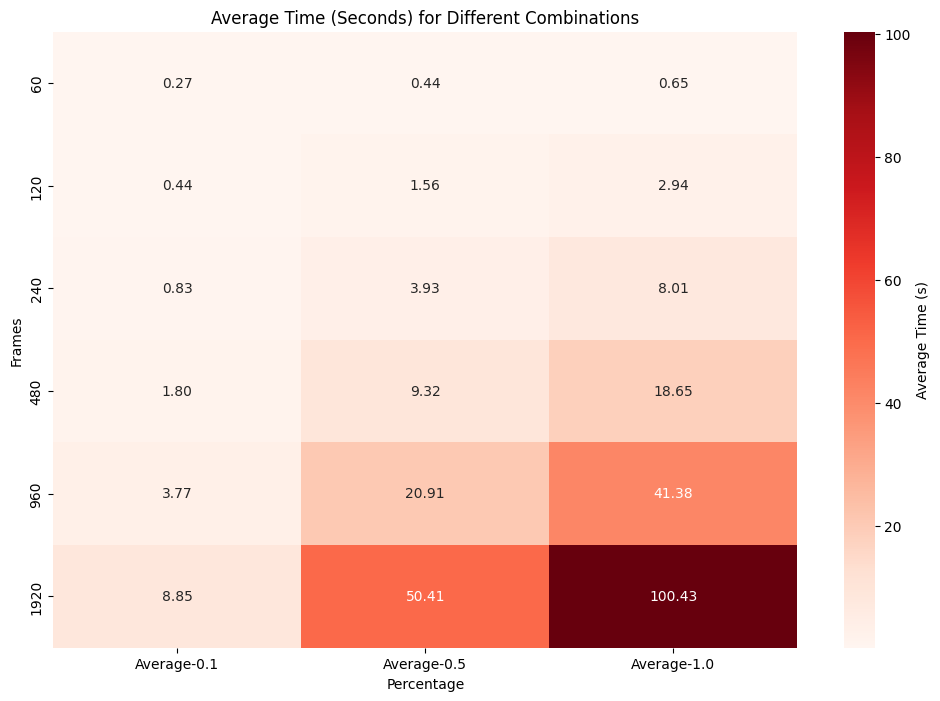

In [33]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_unstacked, annot=True, cmap='Reds', fmt=".2f", cbar_kws={'label': 'Average Time (s)'})
plt.title('Average Time (Seconds) for Different Combinations')
plt.xlabel('Percentage')
plt.ylabel('Frames')
plt.show()

In [34]:
avg_data

{(60, 0.1): 0.26559762954711913,
 (60, 0.5): 0.436625599861145,
 (60, 1): 0.648498821258545,
 (120, 0.1): 0.43794097900390627,
 (120, 0.5): 1.557987380027771,
 (120, 1): 2.939852976799011,
 (240, 0.1): 0.828920316696167,
 (240, 0.5): 3.9341711044311523,
 (240, 1): 8.01070852279663,
 (480, 0.1): 1.804284691810608,
 (480, 0.5): 9.32245683670044,
 (480, 1): 18.650345134735108,
 (960, 0.1): 3.774016523361206,
 (960, 0.5): 20.913725972175598,
 (960, 1): 41.37507152557373,
 (1920, 0.1): 8.849180889129638,
 (1920, 0.5): 50.40898911952972,
 (1920, 1): 100.42574603557587}

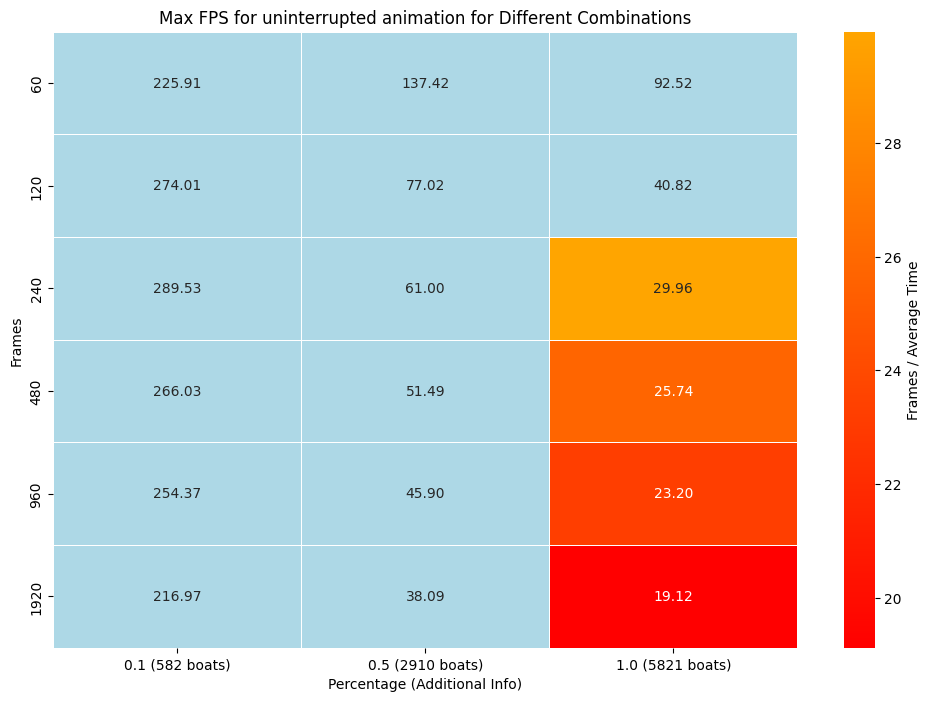

In [41]:
fps_values = {key: key[0] / value for key, value in avg_data.items()}


df_frames_per_value = pd.DataFrame.from_dict(fps_values, orient='index', columns=['Frames_per_Value'])
df_frames_per_value.index = pd.MultiIndex.from_tuples(df_frames_per_value.index, names=['Frames', 'Percentage'])

df_frames_per_value_unstacked = df_frames_per_value.unstack(level=-1)
df_frames_per_value_unstacked.columns = [f"{col} ({number_of_objects[col]} boats)" for col in df_frames_per_value_unstacked.columns.droplevel(0)]

# for values below 30
colors_below_30 = ["red", "orange"]
cmap_below_30 = LinearSegmentedColormap.from_list("Below30Colormap", colors_below_30)

# above 30
colors_above_30 = ["white", "blue"]
cmap_above_30 = LinearSegmentedColormap.from_list("Above30Colormap", colors_above_30)

# Create a mask for values below and above 30
mask_below_30 = df_frames_per_value_unstacked >= 30
mask_above_30 = df_frames_per_value_unstacked < 30

# Plot the heatmap with inverted color gradient for values below 30
plt.figure(figsize=(12, 8))
sns.heatmap(df_frames_per_value_unstacked, annot=True, cmap=cmap_below_30, fmt=".2f", cbar_kws={'label': 'Frames / Average Time'}, mask=mask_below_30, linewidths=.5)
light_blue = "#add8e6"  # 
cmap_single_shade = mcolors.ListedColormap([light_blue])
sns.heatmap(df_frames_per_value_unstacked, annot=True, cmap=cmap_single_shade, fmt=".2f", cbar=False, mask=mask_above_30, linewidths=.5)
plt.title('Max FPS for uninterrupted animation for Different Combinations')
plt.xlabel('Percentage (Additional Info)')
plt.ylabel('Frames')
plt.show()

In [36]:
from collections import deque
def get_folder_size_mb(dir_name):
    total_size = 0
    sizes = deque(maxlen=3)
    for dirpath, dirnames, filenames in os.walk(dir_name):
        for filename in filenames:
            file_path = os.path.join(dirpath, filename)
            # Skip if it is symbolic link
            if not os.path.islink(file_path):
                sizes.append(os.path.getsize(file_path))
    # Convert size to MB
    total_size_mb = sum(sizes) / (1024 * 1024)
    return total_size_mb

In [37]:
memory_used = {}
for combination in times.keys():
    dir_name = f"/home/ali/matrices/{combination[0]}_{combination[1]}"
    size = get_folder_size_mb(dir_name) 
    memory_used[combination] = size
memory_used

{(60, 0.1): 2.110030174255371,
 (60, 0.5): 10.569404602050781,
 (60, 1): 21.157538414001465,
 (120, 0.1): 5.067878723144531,
 (120, 0.5): 26.168395042419434,
 (120, 1): 53.07246017456055,
 (240, 0.1): 11.448563575744629,
 (240, 0.5): 59.421494483947754,
 (240, 1): 121.17325210571289,
 (480, 0.1): 24.267576217651367,
 (480, 0.5): 126.2737226486206,
 (480, 1): 257.8971691131592,
 (960, 0.1): 51.535221099853516,
 (960, 0.5): 272.4908838272095,
 (960, 1): 554.2542095184326,
 (1920, 0.1): 111.01152992248535,
 (1920, 0.5): 589.5363988876343,
 (1920, 1): 1186.8970079421997}

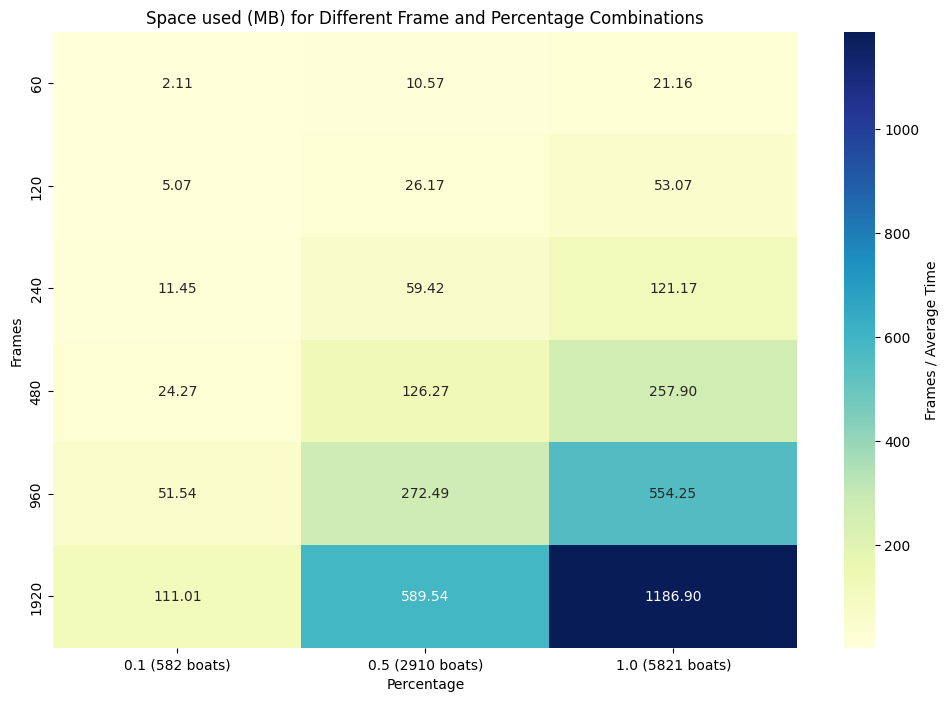

In [38]:


df_frames_per_value = pd.DataFrame.from_dict(memory_used, orient='index', columns=['%'])
df_frames_per_value.index = pd.MultiIndex.from_tuples(df_frames_per_value.index, names=['Frames', 'Percentage'])

df_frames_per_value_unstacked = df_frames_per_value.unstack(level=-1)
df_frames_per_value_unstacked.columns = [f"{col} ({number_of_objects[col]} boats)" for col in df_frames_per_value_unstacked.columns.droplevel(0)]


plt.figure(figsize=(12, 8))
sns.heatmap(df_frames_per_value_unstacked, annot=True, cmap='YlGnBu', fmt=".2f", cbar_kws={'label': 'Frames / Average Time'})
plt.title('Space used (MB) for Different Frame and Percentage Combinations')
plt.xlabel('Percentage')
plt.ylabel('Frames')
plt.show()

In [20]:
number_of_objects

{0.1: 582, 0.5: 2910, 1: 5821}